In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import seaborn as sns

In [2]:
from random import random
from tqdm.notebook import tqdm

In [3]:
import time
import multiprocess as mp

### Read data & preprocessing

In [4]:
df_ref = pd.read_csv('./Data/glioblastoma_BT_S2/ref.csv', index_col = 0)
df_alt = pd.read_csv('./Data/glioblastoma_BT_S2/alt.csv', index_col = 0)

In [5]:
# use multi-index for easier handling of the data
df_ref['chromosome'] = [locus.split('_')[0] for locus in df_ref.index]
df_ref['locus'] = [locus.split('_')[1] for locus in df_ref.index]
df_ref = df_ref.set_index(['chromosome', 'locus'])

df_alt['chromosome'] = [locus.split('_')[0] for locus in df_alt.index]
df_alt['locus'] = [locus.split('_')[1] for locus in df_alt.index]
df_alt = df_alt.set_index(['chromosome', 'locus'])

### Utility functions

### Data generator

### Mutation detection

In [6]:
from mutation_detection import *
from LOH_detection import *

In [7]:
ref = df_ref.to_numpy(dtype = float)
alt = df_alt.to_numpy(dtype = float)
coverages = ref.flatten() + alt.flatten()

In [8]:
posteriors = pd.read_csv('./posteriors.csv', index_col = (0,1)).to_numpy()

In [9]:
mutated_idx, homo_idx = np.where(posteriors[:,3:] > 1 - 1 / posteriors.shape[0])
n_mutated = mutated_idx.size
homos = [['R', 'A'][i] for i in homo_idx]

In [10]:
loss_posteriors = get_loss_posteriors(ref[:50,:], alt[:50,:], homos[:50], {'loss':0.5, 'ret':0.5})

  0%|          | 0/49 [00:00<?, ?it/s]

In [11]:
loss_posteriors

array([2.38182311e-168, 8.87070380e-234, 2.39701926e-002, 2.57100616e-257,
       9.99999986e-001, 1.00000000e+000, 1.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.05704150e-001, 5.38913976e-012, 8.94731065e-282,
       8.82209162e-239, 1.94946685e-004, 2.36057618e-005, 3.63634718e-003,
       3.04972600e-027, 4.90541804e-029, 1.91802160e-004, 5.84005114e-195,
       2.67753865e-225, 1.75609948e-010, 3.82493156e-010, 3.21767562e-005,
       1.52637040e-002, 1.16895678e-002, 7.90210878e-001, 1.19386106e-008,
       6.70464799e-016, 5.67647105e-009, 1.00000000e+000, 1.00000000e+000,
       6.60834544e-021, 6.42495891e-003, 7.06394430e-003, 4.88848373e-008,
       2.99024188e-014, 1.00000000e+000, 1.00000000e+000, 1.03061114e-020,
       4.66876872e-012, 4.20785133e-008, 1.53718560e-050, 5.08363512e-058,
       7.08491184e-003, 1.57957160e-002, 9.78696238e-012, 6.45929400e-003,
       6.74705601e-003])

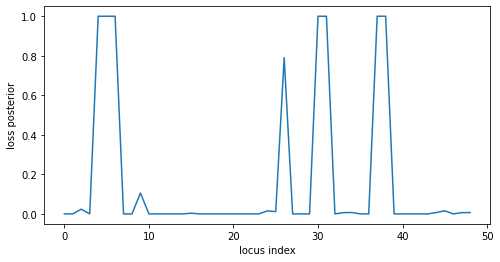

In [16]:
plt.figure(figsize = (8,4))
plt.plot(loss_posteriors)
plt.xlabel('locus index')
plt.ylabel('loss posterior')
plt.show()

### SVD Imputation

In [ ]:
# X: data matrix in which rows (dimension 0) are samples and columns (dimension 1) are features
def mean_impute(X): 
    X_imputed = X.copy() 
    for i in range(X.shape[1]): 
        feature = X[:,i] 
        mean = np.nanmean(feature) # take mean of the feature, ignoring NaN
        if np.isnan(mean): 
            print('[Mean Imputation] WARNING: Empty feature at column %d.'%i) 
        nan_indices = np.where(np.isnan(feature))[0] 
        X_imputed[nan_indices,i] = mean 
    return X_imputed 


def zero_impute(X): 
    X_imputed = X.copy()
    X_imputed[np.isnan(X)] = 0
    return X_imputed
    

def svd_impute(X, rank = None, tol = 0.1, max_iter = 100):
    if rank is None: 
        rank = min(X.shape) // 2
    
    nan_indices = np.where(np.isnan(X))
    X_imputed = zero_impute(X) #initialise all nan entries with the a mean imputation
    
    for i in tqdm(range(max_iter)):
        X_old = X_imputed.copy()
        L,D,R = np.linalg.svd(X_imputed)
        X_approx = L[:,:rank] @ np.diag(D[:rank]) @ R[:rank,:] #rank r approximation of X_imputed
        X_imputed[nan_indices] = X_approx[nan_indices]
        fnorm = np.linalg.norm(X_old - X_imputed, ord="fro")
        if fnorm < tol:
            print('[SVD Imputation]: Converged after %d iterations.'%(i+1))
            print('Frobenius norm:', fnorm)
            break
        if (i+1) >= max_iter:
            print('[SVD Imputation]: Maximum number (%d) of iterations reached.'%(i+1))
            print('Frobenius norm:', fnorm)
    
    return X_imputed

In [ ]:
ref.shape

In [ ]:
np.sum(alt > 5, axis = 1)

In [ ]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize = (16, 12))
    plt.plot(np.sum(alt > 16, axis = 1))
    plt.show()

In [ ]:
for i in range(ref.shape[0]): 
    for j in range(ref.shape[1]): 
        if ref[i,j] == 0 and alt[i,j] == 0:
            ref[i,j] = np.nan
            alt[i,j] = np.nan

In [ ]:
X = np.concatenate([ref, alt], axis = 1)
X_imputed = svd_impute(X, rank = 5)

In [ ]:
X_imputed.shape

In [ ]:
ref_imputed = X_imputed[:,:ref.shape[1]]
alt_imputed = X_imputed[:,ref.shape[1]:]

In [ ]:
ref_proportion = (ref_imputed + 1) / (ref_imputed + alt_imputed + 2)

plt.figure(figsize=(24,16))
plt.imshow(ref_proportion.T, cmap = 'viridis', vmin = 0., vmax = 1.) 
# "viridis": yellow for 1, purple for 0, green/blue for 0.5 (https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html)
plt.xlabel('locus index', fontsize = 17)
plt.ylabel('cell index', fontsize = 17)
plt.show()

### HMM

In [ ]:
# I: initial probability
# T: transition probability (including the begin state)
# E: emission probability
# X: observation
def viterbi(I, T, E, X):
    length = X.shape[0]
    n_states = X.shape[1]
    v = np.zeros((length, n_states)) # v[j, k] = max joint probability having k at step j and emission X[i]
    
    v[0,:] = np.array([I[i] * E(i, X[0]) for i in range(n_states)])
    for j in range(1, length):
        for k in range(n_states):
            v[j,k] = E(k, X[j]) * np.max([v[j-1,l] * T(l,k) for l in range(n_states)]) # l: assumed state of previous step
    
    best_path = np.argmax(v, axis = 1)
    
    return best_path, v[-1, best_path[-1]] # second return is the max joint probability

In [ ]:
transition_matrix = np.array([[0.9, 0.1],
                              [0.5, 0.5]])
def T(pre, post):
    return transition_matrix[pre, post]

In [ ]:
def E(state, obs, f = 0.7, omega = 10):
    n_ref = obs[0]
    coverage = np.sum(obs)
    if state == 1: # normal (heterozygous)
        alpha = (1/2 - 2/3 * f) / omega
        beta = omega - alpha
    elif state == 2: # LOH
        alpha = f * omega
        beta = omega - alpha
    else: 
        print('\n ERROR: invalid state \n')
        return
    
    return betabinom.pmf(n_ref, coverage, alpha, beta)

In [ ]:
X = np.stack((np.array(df_ref.loc['chr1',:])[0,:], np.array(df_alt.loc['chr1',:])[0,:])).T
X